<a href="https://colab.research.google.com/github/hyulianton/jejaringsosial/blob/master/js_Analisis_Jejaring_Bipartite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Jejaring Bipartite: Dataset MovieLens Small

Analisis ini akan memodelkan hubungan antara **Pengguna (User)** dan **Film (Movie)**. Karena hubungan hanya ada *antara* dua jenis entitas ini (Pengguna tidak terhubung langsung dengan Pengguna lain di jejaring awal, dan Film tidak terhubung langsung dengan Film lain), ini disebut **Jejaring Bipartite (Two-Mode Network)**.

## 1. Setup Awal dan Pengunduhan Data

Pertama, kita akan menginstal pustaka yang diperlukan dan mengunduh dataset MovieLens small (sekitar 1 MB).

### 1.1. Instalasi dan Impor Pustaka

In [23]:
# Instalasi pustaka yang diperlukan (hanya perlu di Colab atau jika belum terinstal)
# !pip install pandas networkx matplotlib

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import zipfile
import os
import requests
from io import BytesIO
import random

print("Pustaka berhasil diimpor.")

Pustaka berhasil diimpor.


### 1.2. Pengunduhan dan Ekstraksi Dataset MovieLens

In [2]:
# URL dataset MovieLens Small
url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
zip_path = "ml-latest-small.zip"
extract_dir = "ml-latest-small"

# Download file ZIP
print(f"Mengunduh dataset dari: {url}")
response = requests.get(url)
with open(zip_path, 'wb') as f:
    f.write(response.content)

# Ekstrak file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Tentukan lokasi folder data (biasanya nama folder sama dengan nama file zip tanpa ekstensi)
data_folder = os.path.join(os.getcwd(), 'ml-latest-small')

print(f"Dataset berhasil diunduh dan diekstrak ke: {data_folder}")

Mengunduh dataset dari: http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Dataset berhasil diunduh dan diekstrak ke: /content/ml-latest-small


## 2. Pemuatan dan Pra-Pemrosesan Data

Kita akan memuat file `ratings.csv` untuk mendapatkan hubungan User-Movie dan `movies.csv` untuk mendapatkan nama film (bukan hanya ID).

### 2.1. Memuat Data

In [3]:
# Memuat data
ratings_df = pd.read_csv(os.path.join(data_folder, 'ratings.csv'))
movies_df = pd.read_csv(os.path.join(data_folder, 'movies.csv'))

print(f"Total baris di ratings_df: {len(ratings_df)}")
print(ratings_df.head())
print("-" * 30)
print(movies_df.head())

Total baris di ratings_df: 100836
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
------------------------------
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


### 2.2. Filter Data (Menentukan Hubungan)

Dalam konteks jejaring, kita perlu mendefinisikan apa itu 'hubungan'. Kita akan menganggap hubungan (edge) ada jika seorang pengguna memberikan rating yang cukup tinggi, misalnya **rating 3.0 atau lebih**.


In [12]:
# Filter: Hanya rating 3.0 ke atas yang dianggap sebagai 'koneksi'
THRESHOLD = 3.0
filtered_ratings_df = ratings_df[ratings_df['rating'] >= THRESHOLD].copy() # Gunakan .copy() untuk menghindari SettingWithCopyWarning

print(f"\nTotal koneksi (rating >= {THRESHOLD}): {len(filtered_ratings_df)}")

# Tambahkan prefix 'U' pada userId dan 'M' pada movieId
filtered_ratings_df['user_node'] = 'U' + filtered_ratings_df['userId'].astype(str)
filtered_ratings_df['movie_node'] = 'M' + filtered_ratings_df['movieId'].astype(str)

print("Contoh data dengan prefix:")
print(filtered_ratings_df[['userId', 'user_node', 'movieId', 'movie_node']].head())

# Siapkan daftar tepi (edge list) dengan node yang sudah di-prefix
edge_list_prefixed = filtered_ratings_df[['user_node', 'movie_node']].values.tolist()


Total koneksi (rating >= 3.0): 81763
Contoh data dengan prefix:
   userId user_node  movieId movie_node
0       1        U1        1         M1
1       1        U1        3         M3
2       1        U1        6         M6
3       1        U1       47        M47
4       1        U1       50        M50


## 3. Pembentukan Jejaring Bipartite

Kita akan menggunakan pustaka `networkx` untuk membuat objek graf. Kita perlu mendefinisikan dua partisi: **Users** dan **Movies**.

In [13]:
# 1. Inisialisasi Graf
B = nx.Graph()

# 2. Definisikan Node User dan Node Movie dengan prefix
user_nodes_prefixed = filtered_ratings_df['user_node'].unique()
movie_nodes_prefixed = filtered_ratings_df['movie_node'].unique()

# 3. Tambahkan Node ke Graf
# Label 'bipartite=0' untuk partisi User
B.add_nodes_from(user_nodes_prefixed, bipartite=0)
# Label 'bipartite=1' untuk partisi Movie
B.add_nodes_from(movie_nodes_prefixed, bipartite=1)

# 4. Tambahkan Tepi (Edges) yang sudah di-prefix
B.add_edges_from(edge_list_prefixed)

# Statistik Jejaring Bipartite
num_users = len(user_nodes_prefixed)
num_movies = len(movie_nodes_prefixed)
num_edges = B.number_of_edges()

print(f"\nJejaring Bipartite berhasil dibuat.")
print(f"Jumlah Node User: {num_users}")
print(f"Jumlah Node Movie: {num_movies}")
print(f"Total Node: {B.number_of_nodes()}")
print(f"Total Tepi (Edge): {num_edges}")


Jejaring Bipartite berhasil dibuat.
Jumlah Node User: 609
Jumlah Node Movie: 8452
Total Node: 9061
Total Tepi (Edge): 81763


## 4. Analisis Jejaring Bipartite

### 4.1. Visualisasi (Hanya Sampel)

Visualisasi jejaring bipartite yang besar akan sangat padat. Kita akan memvisualisasikan sampel node dan menggunakan layout khusus untuk bipartite.

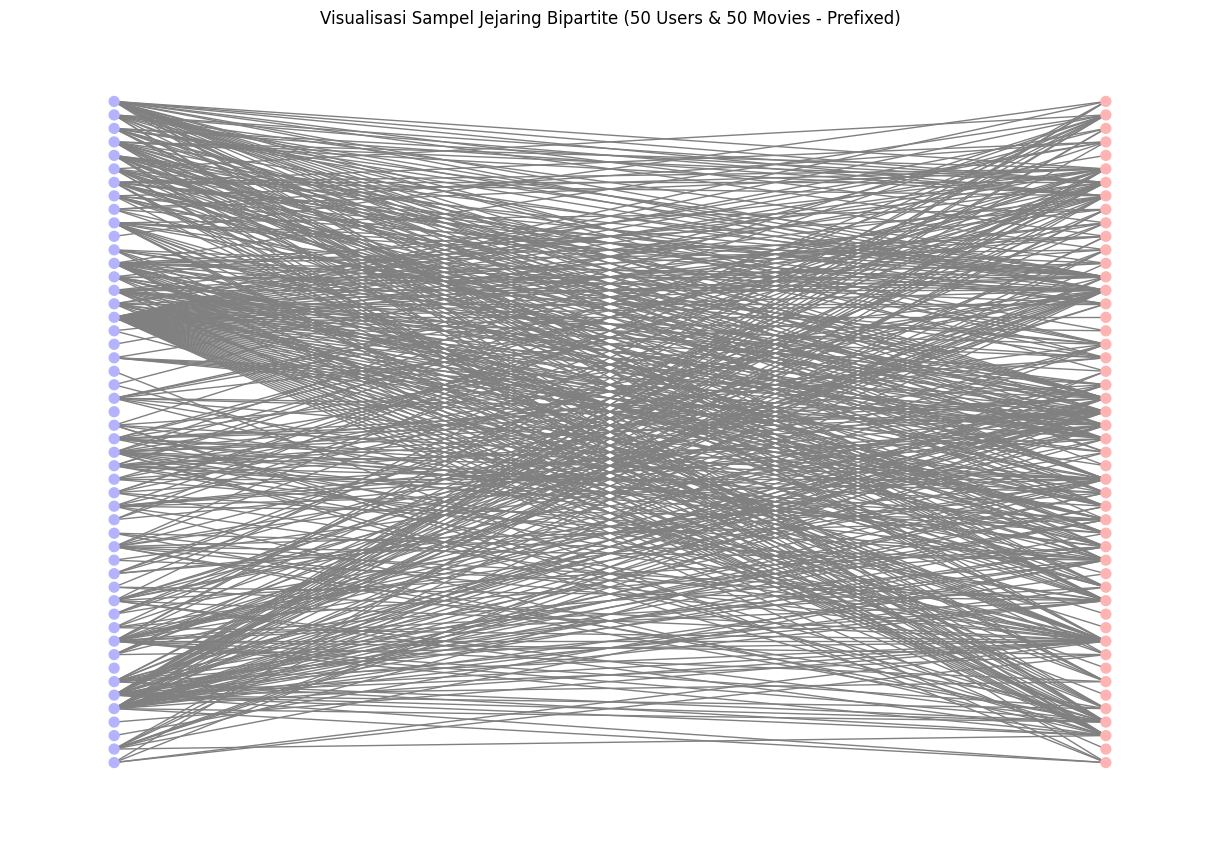

In [14]:
# Ambil 50 node user dan 50 node movie pertama
sample_users = list(user_nodes_prefixed)[:50]
sample_movies = list(movie_nodes_prefixed)[:50]
sample_nodes = sample_users + sample_movies

# Buat subgraph dari sampel node
B_sample = B.subgraph(sample_nodes)

# Tentukan posisi node untuk layout bipartite
top_nodes = [n for n, d in B_sample.nodes(data=True) if d['bipartite'] == 0]
pos = nx.bipartite_layout(B_sample, top_nodes)

plt.figure(figsize=(12, 8))
nx.draw(
    B_sample,
    pos,
    node_color=[(0.7, 0.7, 1) if n.startswith('U') else (1, 0.7, 0.7) for n in B_sample.nodes()],
    node_size=50,
    edge_color='gray',
    with_labels=False
)
plt.title(f"Visualisasi Sampel Jejaring Bipartite (50 Users & 50 Movies - Prefixed)")
plt.show()

### 4.2. Pengukuran Sentralitas Derajat (Degree Centrality)

Sentralitas derajat mengukur seberapa banyak koneksi (rating) yang dimiliki oleh sebuah node.


In [18]:
# Hitung derajat untuk semua node
degrees = dict(B.degree())

# Pisahkan derajat untuk Users dan Movies
user_degrees = {k: v for k, v in degrees.items() if k.startswith('U')}
movie_degrees = {k: v for k, v in degrees.items() if k.startswith('M')}

# Map untuk mencari judul film
movie_titles_map = movies_df.set_index('movieId')['title'].to_dict()

# 5 Film dengan Derajat Tertinggi
top_movies = sorted(movie_degrees.items(), key=lambda item: item[1], reverse=True)[:10]

print("Top 5 Film Paling Populer (Derajat Tertinggi):")
for prefixed_movie_id, degree in top_movies:
    # Hapus prefix 'M' dan konversi kembali ke int untuk mencari judul
    original_movie_id = int(prefixed_movie_id[1:])
    title = movie_titles_map.get(original_movie_id, "Judul Tidak Ditemukan")
    print(f"  - {title} (ID: {original_movie_id}): {degree} rating")

# 5 User Paling Aktif (Derajat Tertinggi)
top_users = sorted(user_degrees.items(), key=lambda item: item[1], reverse=True)[:10]
print("\nTop 5 User Paling Aktif:")
for user_id, degree in top_users:
    # User ID sudah benar ('U123')
    print(f"  - {user_id}: {degree} rating")

Top 5 Film Paling Populer (Derajat Tertinggi):
  - Forrest Gump (1994) (ID: 356): 315 rating
  - Shawshank Redemption, The (1994) (ID: 318): 313 rating
  - Pulp Fiction (1994) (ID: 296): 287 rating
  - Silence of the Lambs, The (1991) (ID: 593): 263 rating
  - Matrix, The (1999) (ID: 2571): 257 rating
  - Star Wars: Episode IV - A New Hope (1977) (ID: 260): 234 rating
  - Braveheart (1995) (ID: 110): 218 rating
  - Jurassic Park (1993) (ID: 480): 216 rating
  - Terminator 2: Judgment Day (1991) (ID: 589): 210 rating
  - Fight Club (1999) (ID: 2959): 206 rating

Top 5 User Paling Aktif:
  - U414: 2117 rating
  - U474: 1750 rating
  - U610: 1159 rating
  - U599: 1104 rating
  - U380: 1093 rating
  - U448: 1075 rating
  - U274: 1035 rating
  - U606: 991 rating
  - U249: 975 rating
  - U68: 929 rating


## 5. Proyeksi Jejaring (One-Mode Projection)

Proyeksi adalah teknik untuk mengubah jejaring bipartite menjadi dua jejaring *one-mode* (tunggal):

1.  **User-User (U-U):** Dua pengguna terhubung jika mereka memiliki **kesamaan dalam film yang di-rating**.
2.  **Movie-Movie (M-M):** Dua film terhubung jika mereka di-rating oleh **pengguna yang sama**.


### 5.1. Proyeksi User-User (Kesesuaian User)


Proyeksi User-User (G_users) berhasil dibuat.
Jumlah User Node: 609
Jumlah Tepi (Edges): 158471


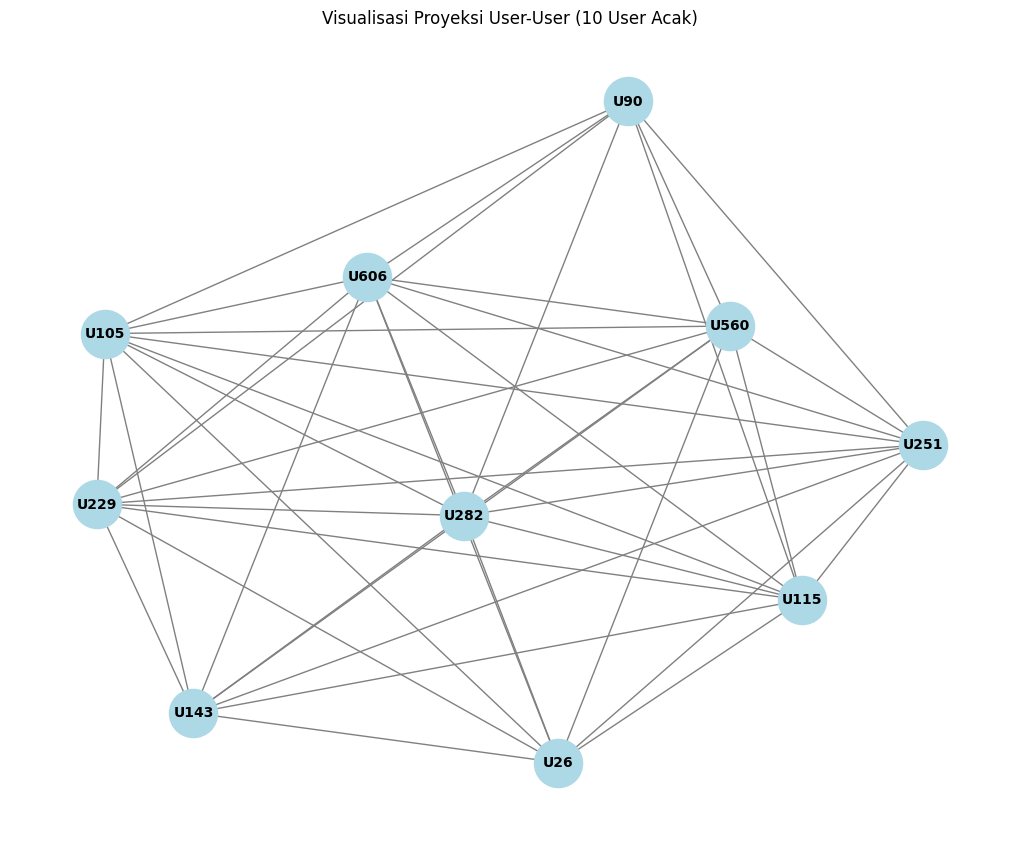


Derajat (Degree) dari 10 User Acak:
  - U115: terhubung dengan 9 user lain yang memiliki selera sama.
  - U26: terhubung dengan 8 user lain yang memiliki selera sama.
  - U282: terhubung dengan 9 user lain yang memiliki selera sama.
  - U251: terhubung dengan 9 user lain yang memiliki selera sama.
  - U229: terhubung dengan 9 user lain yang memiliki selera sama.
  - U143: terhubung dengan 8 user lain yang memiliki selera sama.
  - U105: terhubung dengan 9 user lain yang memiliki selera sama.
  - U560: terhubung dengan 9 user lain yang memiliki selera sama.
  - U90: terhubung dengan 7 user lain yang memiliki selera sama.
  - U606: terhubung dengan 9 user lain yang memiliki selera sama.


In [25]:
# Proyeksi ke partisi Users (menggunakan daftar node yang sudah di-prefix)
G_users = nx.bipartite.projected_graph(B, user_nodes_prefixed)

# Proyeksi User-User sudah dibuat di langkah sebelumnya: G_users

print("Proyeksi User-User (G_users) berhasil dibuat.")
print(f"Jumlah User Node: {G_users.number_of_nodes()}")
print(f"Jumlah Tepi (Edges): {G_users.number_of_edges()}")

# --- PERUBAHAN: Ambil 10 user secara acak ---
N_SAMPLE_USERS = 10
random.seed(42) # Set seed agar hasilnya konsisten
# Mengambil 10 user acak dari seluruh daftar user yang sudah di-prefix
sample_users_random = random.sample(list(user_nodes_prefixed), N_SAMPLE_USERS)

# Buat subgraph dari sampel user acak
random_users_subgraph = G_users.subgraph(sample_users_random)

plt.figure(figsize=(10, 8))
nx.draw_kamada_kawai(
    random_users_subgraph,
    with_labels=True,
    node_size=1200,
    node_color='lightblue',
    font_size=10,
    font_weight='bold',
    edge_color='gray'
)
plt.title(f"Visualisasi Proyeksi User-User ({N_SAMPLE_USERS} User Acak)")
plt.show()

# Analisis Sederhana: Tampilkan derajat user acak ini
print(f"\nDerajat (Degree) dari {N_SAMPLE_USERS} User Acak:")
for user_node in sample_users_random:
    degree = random_users_subgraph.degree(user_node)
    # Tampilkan koneksi di jejaring proyeksi (user ini terhubung dengan degree user lain)
    print(f"  - {user_node}: terhubung dengan {degree} user lain yang memiliki selera sama.")

### 5.2. Proyeksi Movie-Movie (Kesesuaian Konten)



Proyeksi Movie-Movie (G_movies) berhasil dibuat.
Jumlah Movie Node: 8452
Jumlah Tepi (Edges): 8152200


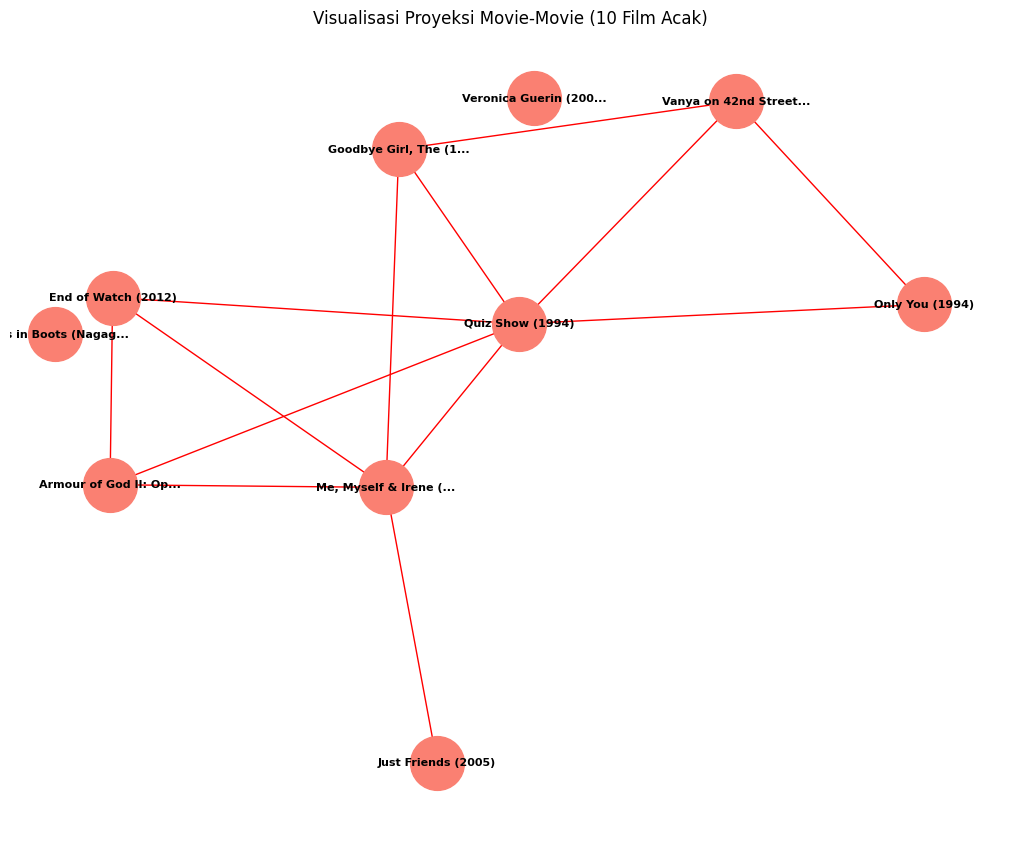


Derajat (Degree) dari 10 Film Acak (Kesesuaian Konten):
  - Veronica Guerin (2003): ditonton bersama 0 film lain oleh user yang sama.
  - Quiz Show (1994): ditonton bersama 6 film lain oleh user yang sama.
  - Armour of God II: Operation Condor (Operation Condor) (Fei ying gai wak) (1991): ditonton bersama 3 film lain oleh user yang sama.
  - Just Friends (2005): ditonton bersama 1 film lain oleh user yang sama.
  - Goodbye Girl, The (1977): ditonton bersama 3 film lain oleh user yang sama.
  - End of Watch (2012): ditonton bersama 3 film lain oleh user yang sama.
  - Vanya on 42nd Street (1994): ditonton bersama 3 film lain oleh user yang sama.
  - Me, Myself & Irene (2000): ditonton bersama 5 film lain oleh user yang sama.
  - Puss in Boots (Nagagutsu o haita neko) (1969): ditonton bersama 0 film lain oleh user yang sama.
  - Only You (1994): ditonton bersama 2 film lain oleh user yang sama.


In [28]:
# Proyeksi ke partisi Movies (menggunakan daftar node yang sudah di-prefix)
G_movies = nx.bipartite.projected_graph(B, movie_nodes_prefixed)

# Proyeksi Movie-Movie sudah dibuat di langkah sebelumnya: G_movies

print("\nProyeksi Movie-Movie (G_movies) berhasil dibuat.")
print(f"Jumlah Movie Node: {G_movies.number_of_nodes()}")
print(f"Jumlah Tepi (Edges): {G_movies.number_of_edges()}")

# --- PERUBAHAN: Ambil 10 movie secara acak ---
N_SAMPLE_MOVIES = 10
random.seed(42) # Gunakan seed yang sama untuk konsistensi
# Mengambil 10 movie acak dari seluruh daftar movie yang sudah di-prefix
sample_movies_random = random.sample(list(movie_nodes_prefixed), N_SAMPLE_MOVIES)

# Buat subgraph dari sampel movie acak
random_movies_subgraph = G_movies.subgraph(sample_movies_random)

# --- PERBAIKAN UTAMA DI SINI: Buat label yang sesuai dengan node subgraph ---
# Buat kamus label baru, dinamakan 'random_movies_labels'
random_movies_labels = {}
for m_prefixed in sample_movies_random:
    # Hapus prefix 'M' dan konversi kembali ke int
    m_id = int(m_prefixed[1:])
    title = movie_titles_map.get(m_id, "Judul Tidak Ditemukan")
    # Batasi panjang judul untuk label
    random_movies_labels[m_prefixed] = title[:20] + "..." if len(title) > 20 else title

plt.figure(figsize=(10, 8))
nx.draw_kamada_kawai(
    random_movies_subgraph,
    # Gunakan kamus label yang baru dibuat
    labels=random_movies_labels,
    node_size=1500,
    node_color='salmon',
    font_size=8,
    font_weight='bold',
    edge_color='red'
)
plt.title(f"Visualisasi Proyeksi Movie-Movie ({N_SAMPLE_MOVIES} Film Acak)")
plt.show()

# Analisis Sederhana: Tampilkan derajat movie acak ini
print(f"\nDerajat (Degree) dari {N_SAMPLE_MOVIES} Film Acak (Kesesuaian Konten):")
for movie_node in sample_movies_random:
    degree = random_movies_subgraph.degree(movie_node)
    # Hapus prefix 'M' dan konversi kembali ke int
    original_movie_id = int(movie_node[1:])
    title = movie_titles_map.get(original_movie_id, "Judul Tidak Ditemukan")
    # Tampilkan koneksi di jejaring proyeksi (film ini ditonton dengan degree film lain)
    print(f"  - {title}: ditonton bersama {degree} film lain oleh user yang sama.")

### Kesimpulan Analisis:

1.  **Jejaring Bipartite (User-Movie):** Modifikasi hubungan awal antara user dan film.
2.  **Analisis Derajat Bipartite:** Mengidentifikasi film yang paling banyak ditonton/disukai dan pengguna yang paling aktif memberikan rating.
3.  **Proyeksi User-User:** Menunjukkan pengguna yang memiliki selera yang sama (karena mereka me-rating film yang sama). Jejaring ini dapat digunakan untuk sistem rekomendasi berbasis kolaboratif.
4.  **Proyeksi Movie-Movie:** Menunjukkan film-film yang dianggap serupa atau sering ditonton bersama oleh audiens yang sama. **Sentralitas Eigenvector** di jejaring ini dapat menunjukkan film-film "kunci" yang menghubungkan komunitas film yang berbeda.